# Adults Census Model Training with Scikit-learn in Azure ML hardware and local hardware

## DecisionTree

[Analysis](#result)

1. Performance metrics for Local and Azure Notebook are equal.
2. Azure Designer Performance metrics are diffrent with locally trained.

**There is no Decision Tree ML Module on the designer**

## Contents

1.	[Load prereqs and data](#prereqs)
2.	[Data scale, Train and evaluate a baseline classifier](#classifier)
3.	[Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%reload_ext watermark
%watermark

2020-11-25T21:46:47+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [3]:
# Initialization:
%reload_ext autoreload
%autoreload 2

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-25 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
sklearn 0.23.2
mlxtend 0.17.3


In [5]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the UCI Adult Dataset

In [6]:
""" UCI Adult Dataset (1994 Census)
    https://archive.ics.uci.edu/ml/machine-learning-databases/adult
    features: 14
    examples: 32561
"""

COLUMNS = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                 "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                 "hours-per-week", "native-country", "income"]
# PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)

df = pd.read_csv('./data/adult.csv', index_col=None)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

new_df = df.loc[:, ~df.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'income'] = le.fit_transform(new_df.loc[:,'income'].values)



In [8]:
new_df.head()

,age,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39,77516,9,13,4,1,4,1,2174,0,40,0
1,50,83311,9,13,2,0,4,1,0,0,13,0
2,38,215646,11,9,0,1,4,1,0,0,40,0
3,53,234721,1,7,2,0,2,1,0,0,40,0
4,28,338409,9,13,2,5,2,0,0,0,40,0


In [9]:
X = new_df.drop('income', axis=1).values
y = new_df['income'].values

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [11]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (22792, 11)
y_train.shape: (22792,)
X_test.shape: (9769, 11)
y_test.shape: (9769,)


<a id="classifier"></a>
## 3. Preprocess ,Train and Evaluate a classifier

1. [Model Training: Fit a DecisionTree via scikit-learn](#3_1)
2. [Evaluate the model](#3_2)

<a id="3_1"></a>
### 3.1. Model Training: Fit a DecisionTree via scikit-learn

Train a model using 

In [12]:
from sklearn.tree import DecisionTreeClassifier

MODEL = "DecisionTreeClassifier"
model = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
model.fit(X_train, y_train)

print(f'model: {model}')

model: DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)


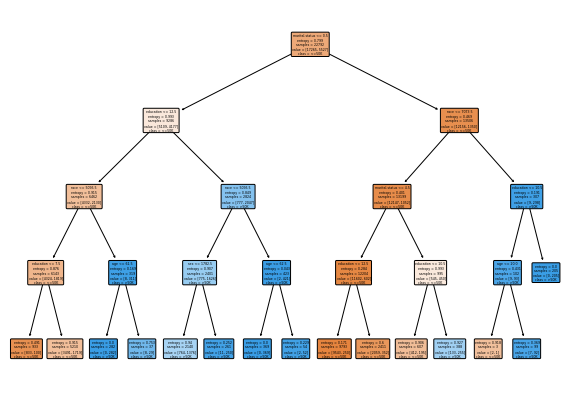

In [13]:
from sklearn.tree import plot_tree

feature_names = COLUMNS[0:len(COLUMNS)-1]

plt.figure(figsize=(10, 7))

plot_tree(model, 
          filled=True, 
          rounded=True,
          class_names=['<=50K', 
                       '>50K'],
          feature_names=feature_names) 
plt.savefig('images/Azure/Exp-2/DecisionTree/tree.png', dpi=300)
plt.show()

<a id="2_2"></a>
### Evaluate the model

Looking at different performance evaluation metrics

In [14]:
# note: micro-average is preferable if you suspect there might be class imbalance
# ref: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
# Import the libraries
from sklearn import metrics

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")

print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 
model.score(X_test, y_test)
print(f'Accuracy:{model.score(X_test, y_test)}')

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

y_pred: [0 0 1 ... 0 0 1]
Misclassified examples:1523
confusion matrix:
 [[7065  390]
 [1133 1181]]
auc: 0.7290288837606452
Accuracy: 0.8440986794963661
Accuracy:0.8440986794963661
Precision: 0.7517504774029281
Recall: 0.510371650821089
F1: 0.607979407979408
classification_report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7455
           1       0.75      0.51      0.61      2314

    accuracy                           0.84      9769
   macro avg       0.81      0.73      0.76      9769
weighted avg       0.84      0.84      0.83      9769



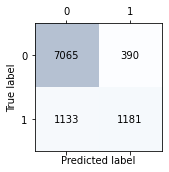

In [15]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Max f1_score on max_depth   13  is  0.6646665128086776


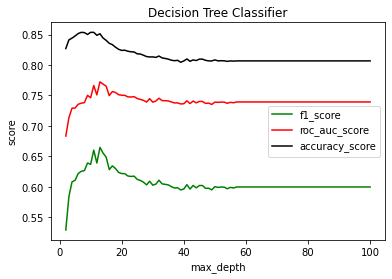

In [16]:
from sklearn import metrics

max_c = 0;
max_j = 0;
y_fsc = []
y_rauc = []
y_acc = []
y_ll = []

x_vals = None

for j in range(2, 101):
    x_vals = np.arange(2, 101)
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=j, random_state=42)
    clf.fit(X_train, y_train)
    threshold = 0.5 # set threshold as 0.5
    y_pred = (clf.predict_proba(X_test)[:,1] >= threshold).astype(int) 
    f_sc = metrics.f1_score(y_test, y_pred)
    y_fsc.append(f_sc)
    r_auc = metrics.roc_auc_score(y_test, y_pred)
    y_rauc.append(r_auc)
    acc = metrics.accuracy_score(y_test, y_pred)
    y_acc.append(acc)
    if f_sc > max_c:
        max_c = f_sc
        max_j = j

print("Max f1_score on max_depth  ",  max_j, " is ", max_c)
plt.figure()
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Decision Tree Classifier')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
plt.plot(x_vals, y_rauc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")
plt.legend()
plt.savefig('images/Azure/Exp-2/DecisionTree/metricssummary.png', dpi=300)
plt.show()

In [55]:
import joblib
joblib.dump(model, f"models/local/adult/{MODEL}.pkl")

['models/local/adult/DecisionTreeClassifier.pkl']

#### Model Trained using Azure Notebook

use to predict

In [17]:
import joblib
clf = joblib.load("./models/azure-adult/adult_DecisionTree.pkl")
print(f"model: {clf}")

# Evaluate model
from sklearn import metrics

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (clf.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")

print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

model: DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
y_pred: [0 0 1 ... 0 0 1]
Misclassified examples:1523
confusion matrix:
 [[7065  390]
 [1133 1181]]


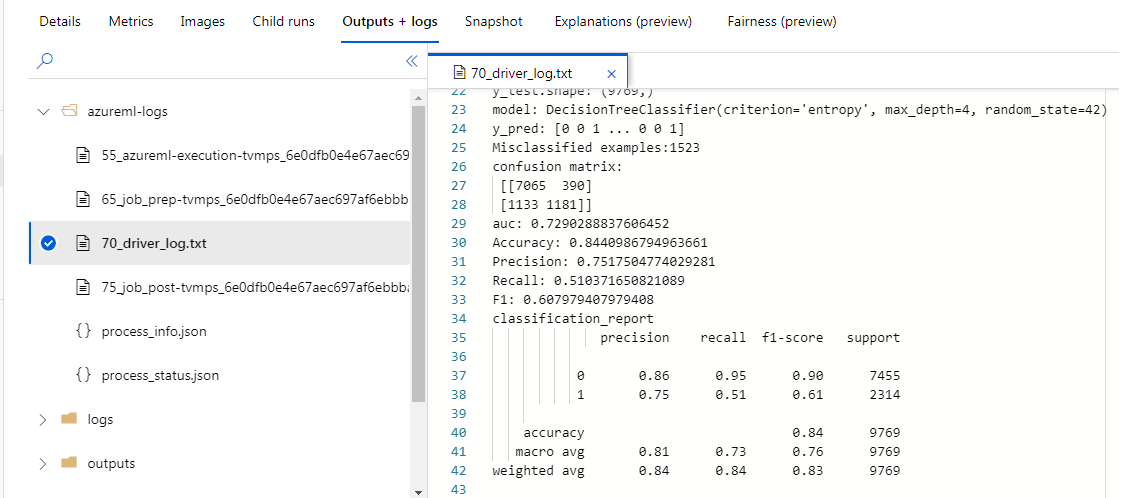

In [56]:
Image(filename='images/Azure/Exp-2/DecisionTree/driver_log.png')

<a id="result"></a>
### Result Analysis

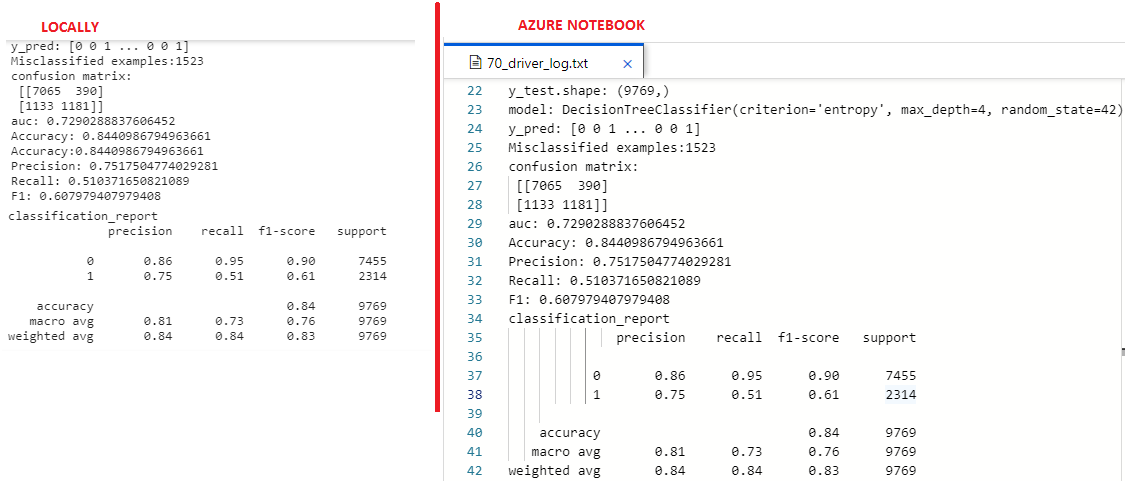

In [57]:
Image(filename='images/Azure/Exp-2/DecisionTree/result.png')

## 5 Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [ ]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

### Experiment : 2

Generate adversarial samples:

In [ ]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

1. Score
2. Predict

##### Score

In [ ]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

In [ ]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

#### Predict

In [ ]:
print(X_train[0:5, :])
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

In [ ]:
print(X_train_adv[0:5, :])
prediction = model.predict(X_train_adv[0:5, :])
prediction
print(f"Adversarial Training Predicted Label: {prediction}")

##### Test score

In [ ]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

In [ ]:
print(X_test[:5, :])
prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

In [ ]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

In [ ]:
print(X_test_adv[0:5, :])
prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")